In [13]:
import sys
sys.path.append('./models/')
from Model import Model
from Arima import ARIMA_Model, VAR_m
from exponential_regression import ExponentialRegression, MultiDimensionalExponentialRegression
from SIRH  import *
from LinearRegression import *
from BayesianRegression import *
from moving_average import MovingAverage, MovingAverageMulti
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from evaluate_model import evaluate_model, evaluate_model_multi, evaluate_model_multi_RMSE, evaluate_model_RMSE
import json

In [14]:
df=pd.read_csv('hopitalized_and_infectious.csv')
df.drop(['Unnamed: 0'], axis=1, inplace=True)
n_hospitalized=np.array(df['hospitalized'])
n_infectious=np.array(df['n_infectious'])


In [15]:
# importing mobility from the csv file
df_mobility=pd.read_csv('mobility_bis.csv')
df_mobility.drop(columns=['Unnamed: 0'], inplace=True)
mobility=np.array(df_mobility['mobility'])


In [16]:
#Processing of mobility data
relier_les_points=[]
for i in range(len(mobility)): 
    if i + 7 < len(mobility): 
        if i % 7 ==0:
            relier_les_points.append(mobility[i])
        else: 
            decalage=i-7*(i//7)
            res = (1-decalage/7)*mobility[7*(i//7)] + (decalage/7)*mobility[7*(i//7)+7]

            relier_les_points.append(res)
    else:
        relier_les_points.append(mobility[i])
mobility_smoothed=np.array(relier_les_points)
data3D=np.array([n_hospitalized, n_infectious, mobility_smoothed])

In [17]:
alpha=0.05 #Confidence interval at 100(1-alpha)%
myarima=ARIMA_Model()
mysirh=SIRH_model_2()
mysirh.choose_model(True, False, True)
mybayes=BayesianRegressionModel()
mylinear=LinearRegressionModel()

mysirh_multi=Multi_SIRH_model()
mysirh_multi.choose_model(False,False)
myvar=VAR_m()

In [28]:
def generate_prediction(model: Model, data: np.array, alpha: int, start: int, horizon: int):
    n_hospitalized_trunc=data[0][:start]
    n_infectious_trunc=data[1][:start]
    mobility_smoothed_trunc=data[2][:start]
    
    model.train(train_dates = [i for i in range(start)], data = np.array([n_hospitalized_trunc, n_infectious_trunc, mobility_smoothed_trunc]))
    intervals=[]
    reach=[i for i in range(1, horizon)]
    predict=[]
    CI=[]
    for R in reach:
        print(R)
        prediction, interval = model.predict(R, alpha)
        predict.append(prediction)
        interval_low=interval[0][-1]
        interval_high=interval[1][-1]
        intervals.append((interval_low, interval_high))
    return intervals, prediction

In [33]:

start_date=100 #160
horizon=10
#CI, predict=generate_prediction(model=mysirh, data=n_hospitalized, alpha=alpha, start=start_date, horizon=horizon)
CI, predict=generate_prediction(model=myvar, data=data3D, alpha=alpha, start=start_date, horizon=horizon)

1
2
3
4
5
6
7
8
9


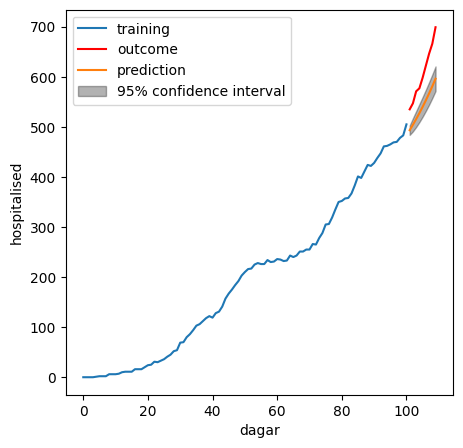

In [34]:
dates=np.arange(start_date+1,start_date+horizon)
ci = np.asarray(CI)
plt.figure(figsize=(5,5), dpi=100)
plt.plot(n_hospitalized[0:start_date+1], label='training')
plt.plot(dates,n_hospitalized[start_date+2:start_date+1+horizon], color='red',label='outcome')
plt.plot(dates,predict,label='prediction')
plt.fill_between(dates,ci[:,0], ci[:,1], color='black', alpha=.3, label='95% confidence interval')
plt.xlabel('dagar')
plt.ylabel('hospitalised')
plt.legend()
plt.savefig('linear.pdf')

In [ ]:
#Save to Excel
n_hospitalized_train = n_hospitalized[0:start_date + 1]
n_hospitalized_outcome = n_hospitalized[start_date + 2:start_date + 1 + horizon]
days=[i for i in range(1,start_date + 1 + horizon)]
predict_values = predict
df = pd.DataFrame({
    'Dates': days,
    'Training Hospitalized': np.append(n_hospitalized_train, [np.nan] * (len(dates) )),
    'Prediction': np.append([np.nan] * len(n_hospitalized_train), predict_values),
    'CI Lower': np.append([np.nan] * len(n_hospitalized_train),ci[:, 0]),
    'CI Upper': np.append([np.nan] * len(n_hospitalized_train),ci[:, 1]),
    'Outcome Hospitalized': np.append([np.nan] * len(n_hospitalized_train), n_hospitalized_outcome)
})

# Write the DataFrame to an Excel file
df.to_excel('plot_data.xlsx', index=False)

ModuleNotFoundError: No module named 'openpyxl'

306


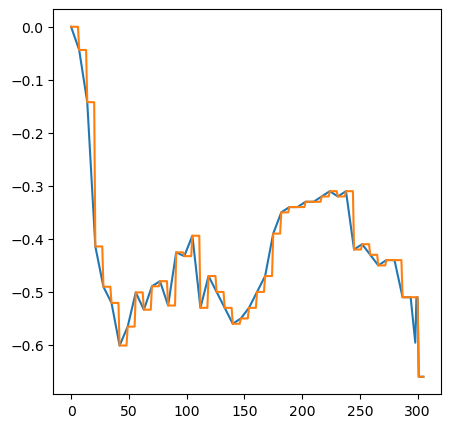

In [ ]:
plt.figure(figsize=(5,5), dpi=100)
plt.plot(mobility_smoothed, label='training')
plt.plot(mobility)
print(len(mobility_smoothed))